In [1]:
import numpy as np
import matplotlib.pyplot as plt
import burst_detector as bd
import seaborn as sns
from scipy.stats import wasserstein_distance
import pandas as pd
import math
import multiprocess as mp
from multiprocess.pool import ThreadPool as Pool
import itertools
import functools

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
n_chan = 128
times = np.load('../data/midbrain_cullen/KS2.5_preprocessed/spike_times.npy').flatten()
clusters = np.load('../data/midbrain_cullen/KS2.5_preprocessed/spike_clusters.npy').flatten()
# mean_wf = np.load("../data/midbrain_cullen/KS2.5_preprocessed/mean_waveforms.npy")

counts = bd.spikes_per_cluster(clusters)
labels = pd.read_csv("../data/midbrain_cullen/KS2.5_preprocessed/cluster_group.tsv", sep="\t")

In [4]:
# load raw data
rawData = np.memmap("../data/midbrain_cullen/NPX_001_Session_2_preprocessed.bin", dtype='int16', mode='r')
global data
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [5]:
# dictionary for function testing

params = {}

# mean calculation
params['calc_means'] = True
params['fs'] = 30000
params['n_chan'] = 128
params['pre_samples'] = 20
params['post_samples'] = 62
params['max_spikes'] =  -1

# mean sim
params['jitter'] = True
params['jitter_amt'] = 4
params['sim_thresh'] = .4
params['sp_num_thresh'] = 100

# xcorr metric
params['n_iter'] = 50
params['shuffle_bin_width'] = 0.1
params['window_size'] = 0.01
params['xcorr_bin_width'] = 0.0005
params['overlap_tol'] = 10/params['fs']
params['max_window'] = 0.1
params['min_xcorr_rate'] = .8/.001

# ref p
params['xcorr_ref_p'] = 0.0005

### Mean Similarity

In [6]:
# Calculate mean waveforms
# n_clust = clusters.max() + 1
# mean_wf = np.zeros((n_clust, n_chan, 82))

# for i in range(n_clust):
#     if i in np.unique(clusters):
#         spikes = bd.extract_spikes(data, times, clusters, i, n_chan=128, max_spikes=-1)
#         mean_wf[i,:,:] = spikes.mean(axis=0)
    
#     if i % 10 == 0:
#         print("Done with %d" %i)

# np.save("merge_dat/midbrain_mean_wf", mean_wf)

mean_wf = np.load("merge_dat/midbrain_mean_wf.npy")

# ~ 54 s

In [7]:
# # create mask for non-noise cluster pairs with enough spikes
# mean_sim, offset, wf_means_norm = bd.wf_means_similarity(mean_wf, jitter=True)

# sim_thresh = .4
# sp_num_thresh = 100

# pass_1 = np.zeros_like(mean_sim, dtype='bool')
# for c1 in range(counts.shape[0]): 
#     for c2 in range(c1+1, counts.shape[0]):
        
#         # keep similar cluster pairs where one has sufficient spikes and both are not noise
#         if mean_sim[c1,c2] >= sim_thresh and ((counts[c1] >= sp_num_thresh) or (counts[c2] >= sp_num_thresh)):
#             if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
#                 pass_1[c1,c2] = True
#                 pass_1[c2,c1] = True

In [8]:
# plt.figure(figsize=(6,6))
# plt.imshow(mean_sim)
# plt.colorbar(); plt.title("Mean waveform similarity in monkey midbrain");

Mean sim function test

In [9]:
ms, o, wmn, mw, pm = bd.stages.calc_mean_sim(data, times, clusters, counts, labels, None, params)

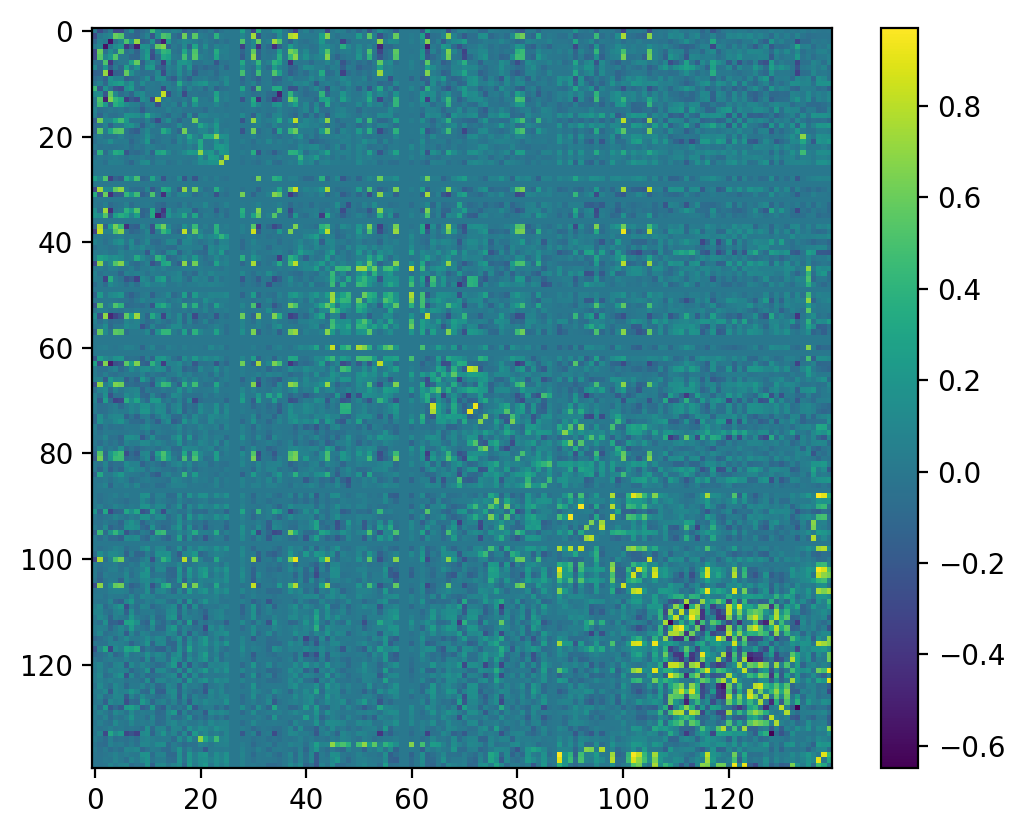

In [10]:
plt.imshow(ms); plt.colorbar();

### Cross projection similarity

In [11]:
spikes = {}
for i in range(counts.shape[0]):
    spikes[i] = bd.extract_spikes(data, times, clusters, i,n_chan=n_chan, max_spikes=2000)

In [12]:
# #compute waveform similarity
# num  = 0
# wass_d = np.ones_like(mean_sim)

# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
        
#         # keep similar cluster pairs where one has sufficient spikes and both are not noise
#         if mean_sim[c1,c2] >= sim_thresh and ((counts[c1] >= sp_num_thresh) or (counts[c2] >= sp_num_thresh)):
#             if (labels.iloc[c1]['group'] == 'good') and (labels.iloc[c2]['group'] == 'good'):
                
#                 #extract spikes
#                 sp_1 = spikes[c1]
#                 sp_2 = spikes[c2]
                
#                 # compute cross-projections
#                 proj_1on1, proj_2on1, proj_1on2, proj_2on2 = bd.cross_proj(sp_1, sp_2, wf_means_norm[c1], wf_means_norm[c2], offset=offset[c1, c2])
                
#                 # bound outliers
#                 dist_1on2 = proj_1on2/proj_1on1
#                 dist_1on2[dist_1on2 > 1] = 1
#                 dist_1on2[dist_1on2 < 0] = 0
                
#                 dist_2on1 = proj_2on1/proj_2on2
#                 dist_2on1[dist_2on1 > 1] = 1
#                 dist_2on1[dist_2on1 < 0] = 0
                
#                 # compute wasserstein distances
#                 wass_d[c1, c2] = wasserstein_distance(proj_1on1/proj_1on1, dist_1on2)
#                 wass_d[c2, c1] = wasserstein_distance(proj_2on2/proj_2on2, dist_2on1)
                
#                 num += 1
#                 if (num % 10 == 0):
#                     print("finished pair %d" % num)
                    
# np.save("merge_dat/midbrain_maxspikes_wass_d.npy", wass_d)

# wass_d = np.load("merge_dat/midbrain_maxspikes_wass_d.npy")
# wass_sim = 1 - wass_d

# # ~ 1 min 20 s

In [13]:
# plt.scatter(mean_sim[pass_1].flatten(), wass_sim[pass_1].flatten());

In [14]:
# wass_sim = 1-wass_d
# plt.imshow(wass_sim)
# plt.colorbar(); plt.title("1 - Wasserstein distance in monkey midbrain");

In [15]:
# wass_sim = 1-wass_d

# merge_dec = np.zeros_like(mean_sim)
# wass_thresh = 0.75
# num = 0

# for c1 in range(counts.shape[0]): 
#     for c2 in range(c1+1, counts.shape[0]):
        
#         # keep similar cluster pairs where both have sufficient spikes and are not noise
#         if pass_1[c1,c2]:
#             if (wass_sim[c1, c2] * wass_sim[c2, c1] > wass_thresh**2):
#                 merge_dec[c1, c2] = 1
#                 merge_dec[c2, c1] = 1                

In [16]:
# plt.imshow(merge_dec)
# plt.colorbar();
# plt.title("Waveform-based merge decisions in monkey midbrain");

#### Cross proj function test

In [17]:
cs = bd.stages.calc_cross_sim(spikes, wmn, o, pm, counts)

In [18]:
data= None
spikes = None

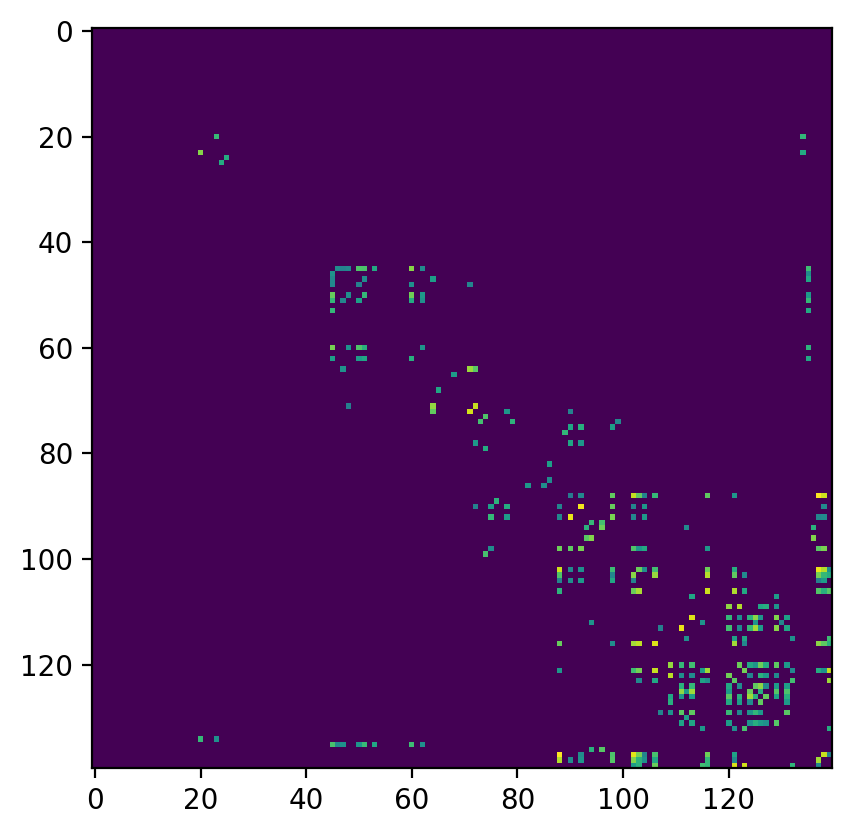

In [19]:
plt.imshow(cs);

### Cross-correlation metric

In [20]:
# def xcorr_func(c1, c2, times, clusters, xcorr_window, xcorr_bin_width, max_window):
#     import burst_detector as bd
    
#     print(c1,c2)
#     # extract spike times
#     cl_times = bd.find_times_multi(times/30000, clusters, [c1, c2])
#     c1_times = cl_times[0]
#     c2_times = cl_times[1]

#     # compute xgrams
#     return bd.calc_xgrams(
#         c1_times, 
#         c2_times,
#         n_iter=50,
#         window_size=max_window,
#         xcorr_bin_width=xcorr_bin_width, 
#         overlap_tol=10/30000
#     )

# xcorr_job = functools.partial(
#     xcorr_func, 
#     times=times, 
#     clusters=clusters,
#     xcorr_window=.01,
#     xcorr_bin_width=.0005,
#     max_window=.1
# )

In [21]:
# pool = mp.Pool(mp.cpu_count())
# args = []

# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
#         if pass_1[c1, c2]:
#             args.append((c1,c2))

# res = pool.starmap(xcorr_job, args)

In [22]:
# # convert output to np arrays
# xgrams = np.empty_like(mean_sim, dtype='object')
# x_olaps = np.zeros_like(mean_sim)
# shfl_xgrams = np.empty_like(mean_sim, dtype='object')
# shfl_olaps = np.zeros_like(mean_sim)

# for i in range(len(res)):
#     c1 = args[i][0]
#     c2 = args[i][1]
    
#     xgrams[c1,c2] = res[i][0]
#     x_olaps[c1,c2] = res[i][1]
#     shfl_xgrams[c1,c2] = res[i][2]
#     shfl_olaps[c1,c2] = res[i][3]

In [23]:
# # compute ccgs and shuffled ccgs
# num = 0
# xgrams = np.empty_like(mean_sim, dtype='object')
# x_olaps = np.zeros_like(mean_sim)
# shfl_xgrams = np.empty_like(mean_sim, dtype='object')
# shfl_olaps = np.zeros_like(mean_sim)

# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
#         if pass_1[c1, c2]:
#             # extract spike times
#             cl_times = bd.find_times_multi(times/30000, clusters, [c1, c2])
#             c1_times = cl_times[0]
#             c2_times = cl_times[1]
                
#             # adaptive bin size
#             max_window = .1
#             xcorr_window = .010
#             xcorr_bin_width = .0005
                
#             # compute xgrams
#             xgram, x_olap, shfl_xgram, shfl_olap = bd.calc_xgrams(
#                 c1_times, 
#                 c2_times,
#                 n_iter=50,
#                 window_size=max_window, 
#                 xcorr_bin_width=xcorr_bin_width, 
#                 overlap_tol=10/30000
#             )           
            
#             xgrams[c1,c2] = xgram
#             x_olaps[c1,c2] = x_olap
#             shfl_xgrams[c1,c2] = shfl_xgram
#             shfl_olaps[c1,c2] = shfl_olap
            
#             num += 1
#             if (num % 10 == 0):
#                 print("finished pair %d" % num)
                
# np.save("midbrain_xgrams.npy", xgrams)
# np.save("midbrain_x_olaps.npy", x_olaps)
# np.save("midbrain_shfl_xgrams.npy", shfl_xgrams)
# np.save("midbrain_shfl_olaps.npy", shfl_olaps)

# xgrams = np.load("merge_dat/midbrain_xgrams.npy", allow_pickle=True)
# x_olaps = np.load("merge_dat/midbrain_x_olaps.npy")
# shfl_xgrams = np.load("merge_dat/midbrain_shfl_xgrams.npy", allow_pickle=True)
# shfl_olaps = np.load("merge_dat/midbrain_shfl_olaps.npy")

# # 26 mins

In [24]:
# # compute cross-correlation
# num  = 0
# xcorr_sig = np.zeros_like(mean_sim)

# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
#         if pass_1[c1,c2]:
#             # adaptive bin size
#             xcorr_window = .010
#             xcorr_bin_width = .0005

#             # compute significance
#             xcorr_sig[c1,c2] = bd.xcorr_sig(xgrams[c1,c2], shfl_xgrams[c1,c2], window_size=xcorr_window, xcorr_bin_width=xcorr_bin_width,  min_xcorr_rate=.8/.001, max_window=.1)

# # copy across the diagonal
# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
#         xcorr_sig[c2,c1] = xcorr_sig[c1,c2]

In [25]:
# plt.imshow(xcorr_sig); plt.colorbar();
# plt.title("Cross-correlation significance for cluster-pairs with inner product > 0.4");

#### Xcorr function test

In [26]:
xs, xg, sxg = bd.stages.calc_xcorr_metric(times, clusters, counts, pm, params)

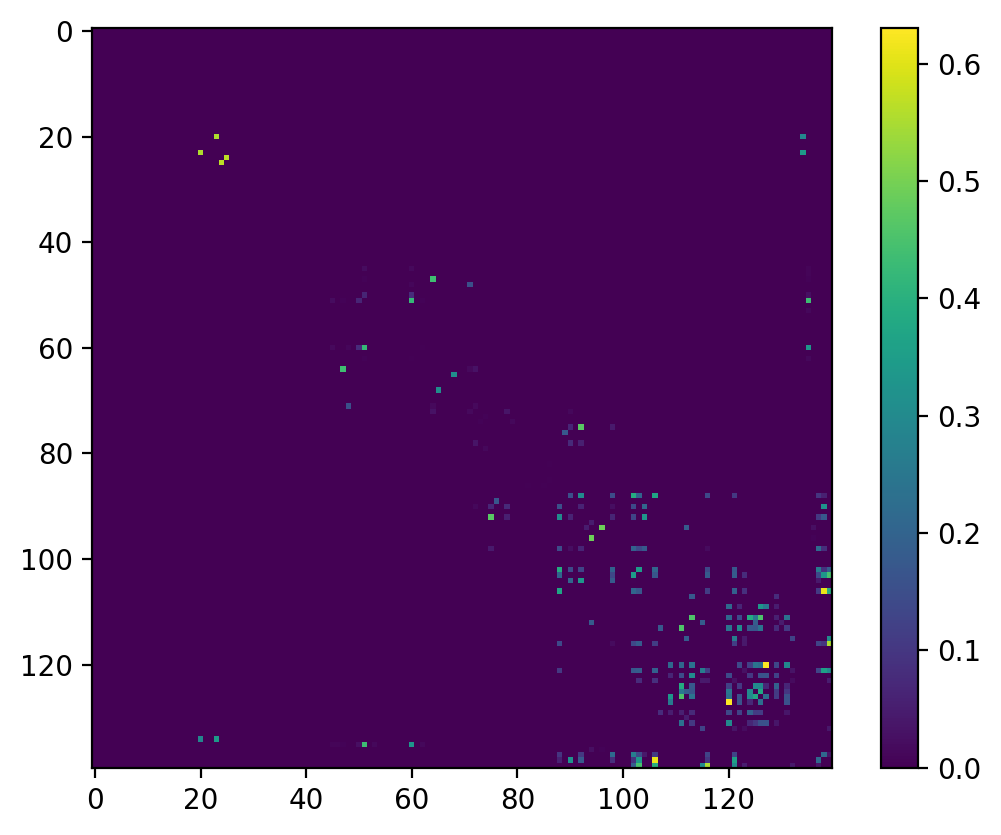

In [27]:
plt.imshow(xs); plt.colorbar();

### Refractory period penalty

In [28]:
# def ref_p_func(c1, c2, times, clusters, xcorr_bin_width, xcorr_ref_p, xgrams, shfl_xgrams):
#     import burst_detector as bd
    
#     # extract spike times
#     cl_times = bd.find_times_multi(times/30000, clusters, [c1, c2])
#     c1_times = cl_times[0]
#     c2_times = cl_times[1]

#     # adaptive bin size
#     xcorr_bin_width = .0005
#     xcorr_ref_p = .0005

#     # find refractory period bin indices
#     xgram = xgrams[c1,c2]
#     num_bins = round(xcorr_ref_p/xcorr_bin_width)

#     ref_start =int(xgram.shape[0]/2) - num_bins
#     ref_end = int(xgram.shape[0]/2) - 1 + num_bins

#     # calculate and scale autocorrelograms
#     c1_autocg = bd.auto_correlogram(c1_times, bin_width=xcorr_bin_width)
#     c2_autocg = bd.auto_correlogram(c2_times, bin_width=xcorr_bin_width)

#     # scale and check for empty autocgs
#     if (c1_autocg.max() == 0) and (c2_autocg.max() == 0):
#         ref_pen[c1,c2] = 0
#         return 0

#     elif (c1_autocg.max() == 0):
#         c1_autocg = np.zeros_like(c1_autocg)
#         c2_autocg /= c2_autocg.max()

#     elif (c2_autocg.max() == 0):
#         c2_autocg = np.zeros_like(c2_autocg)
#         c1_autocg /= c1_autocg.max()

#     else:
#         c1_autocg /= c1_autocg.max()
#         c2_autocg /= c2_autocg.max()   

#     # calculate and scale bounds
#     ref_viol_low = min(c1_autocg[ref_start:ref_end+1].sum(), c2_autocg[ref_start:ref_end+1].sum())
#     ref_viol_high = (shfl_xgrams[c1,c2][ref_start:ref_end+1].sum())

#     ref_viol_high /= shfl_xgrams[c1,c2].max()

#     # calculate ref period penalty
#     ref_viol_ccg = (xgrams[c1,c2][ref_start:ref_end+1].sum())
#     ref_viol_ccg /= shfl_xgrams[c1,c2].max()

#     return bd.calc_ref_pen(ref_viol_ccg, ref_viol_low, ref_viol_high)

# ref_p_job = functools.partial(
#     ref_p_func, 
#     times=times, 
#     clusters=clusters,
#     xcorr_bin_width=.0005,
#     xcorr_ref_p =.0005,
#     xgrams=xg,
#     shfl_xgrams=sxg
# )

In [29]:
# pool = mp.Pool(mp.cpu_count())
# args = []

# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
#         if (pm[c1,c2]) and xs[c1,c2] > 0:
#             args.append((c1,c2))

# res = pool.starmap(ref_p_job, args)

In [30]:
# ref_pen = np.zeros_like(ms)

# for i in range(len(res)):
#     c1 = args[i][0]
#     c2 = args[i][1]
    
#     ref_pen[c1,c2] = res[i]
#     ref_pen[c2,c1] = res[i]

In [31]:
# ref_pen = np.zeros_like(mean_sim)

# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
#         if (pass_1[c1,c2]) and xcorr_sig[c1,c2] > 0:
            
#             # extract spike times
#             cl_times = bd.find_times_multi(times/30000, clusters, [c1, c2])
#             c1_times = cl_times[0]
#             c2_times = cl_times[1]
            
#             # adaptive bin size
#             xcorr_bin_width = .0005
#             xcorr_ref_p = .0005
            
#             # find refractory period bin indices
#             xgram = xgrams[c1,c2]
#             num_bins = round(xcorr_ref_p/xcorr_bin_width)

#             ref_start =int(xgram.shape[0]/2) - num_bins
#             ref_end = int(xgram.shape[0]/2) - 1 + num_bins
            
#             # calculate and scale autocorrelograms
#             c1_autocg = bd.auto_correlogram(c1_times, bin_width=xcorr_bin_width)
#             c2_autocg = bd.auto_correlogram(c2_times, bin_width=xcorr_bin_width)
            
#             # scale and check for empty autocgs
#             if (c1_autocg.max() == 0) and (c2_autocg.max() == 0):
#                 ref_pen[c1,c2] = 0
#                 continue
                
#             elif (c1_autocg.max() == 0):
#                 c1_autocg = np.zeros_like(c1_autocg)
#                 c2_autocg /= c2_autocg.max()
                
#             elif (c2_autocg.max() == 0):
#                 c2_autocg = np.zeros_like(c2_autocg)
#                 c1_autocg /= c1_autocg.max()
            
#             else:
#                 c1_autocg /= c1_autocg.max()
#                 c2_autocg /= c2_autocg.max()   
            
#             # calculate and scale bounds
#             ref_viol_low = min(c1_autocg[ref_start:ref_end+1].sum(), c2_autocg[ref_start:ref_end+1].sum())
#             ref_viol_high = (shfl_xgrams[c1,c2][ref_start:ref_end+1].sum())
            
#             ref_viol_high /= shfl_xgrams[c1,c2].max()
            
#             # calculate ref period penalty
#             ref_viol_ccg = (xgrams[c1,c2][ref_start:ref_end+1].sum())
#             ref_viol_ccg /= shfl_xgrams[c1,c2].max()
            
#             ref_pen[c1,c2] = bd.calc_ref_pen(ref_viol_ccg, ref_viol_low, ref_viol_high)

In [32]:
# # copy across the diagonal
# for c1 in range(counts.shape[0]):
#     for c2 in range(c1+1, counts.shape[0]):
#         ref_pen[c2,c1] = ref_pen[c1,c2]

In [33]:
# plt.imshow(ref_pen); plt.colorbar();

#### Refractory penalty 

In [34]:
rp = bd.stages.calc_ref_p(times, clusters, counts, pm, xs, xg, sxg, params)

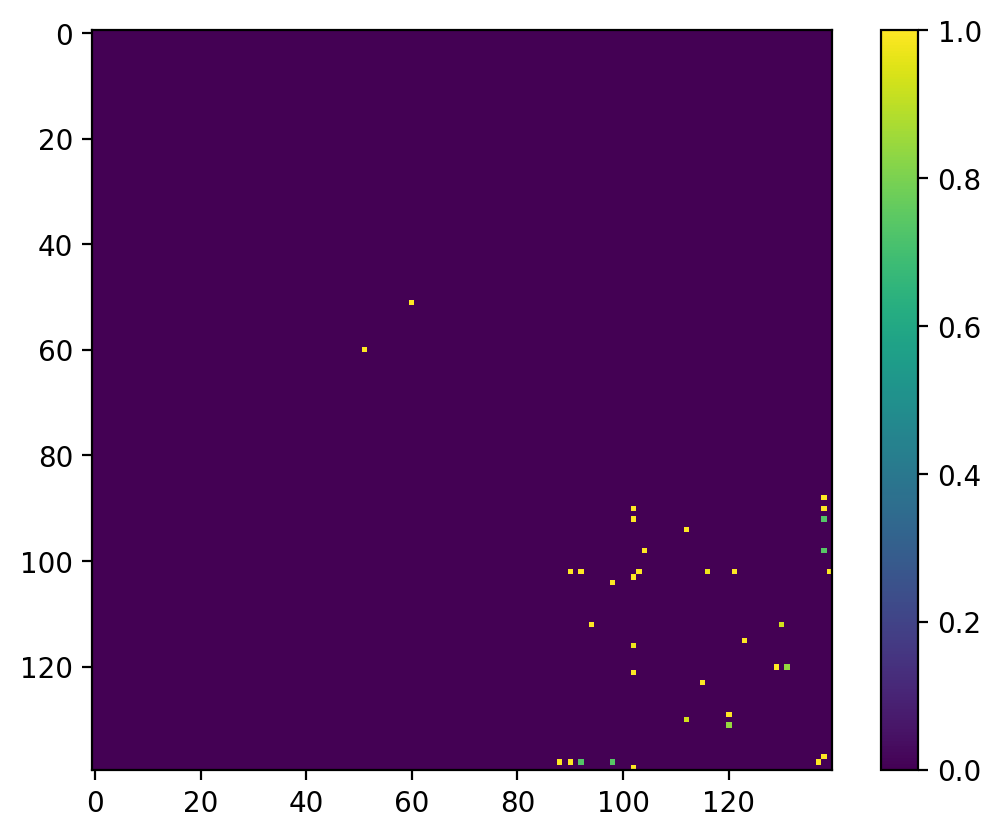

In [35]:
plt.imshow(rp); plt.colorbar();

### Final metric

In [36]:
final_metric = np.zeros_like(ms)

for c1 in range(counts.shape[0]):
    for c2 in range(c1, counts.shape[0]):
        val = np.sqrt(cs[c1,c2]*cs[c2,c1]) + .5*xs[c1,c2] - .5*rp[c1,c2]
        final_metric[c1,c2] = max(val,0)
        final_metric[c2,c1] = max(val,0)

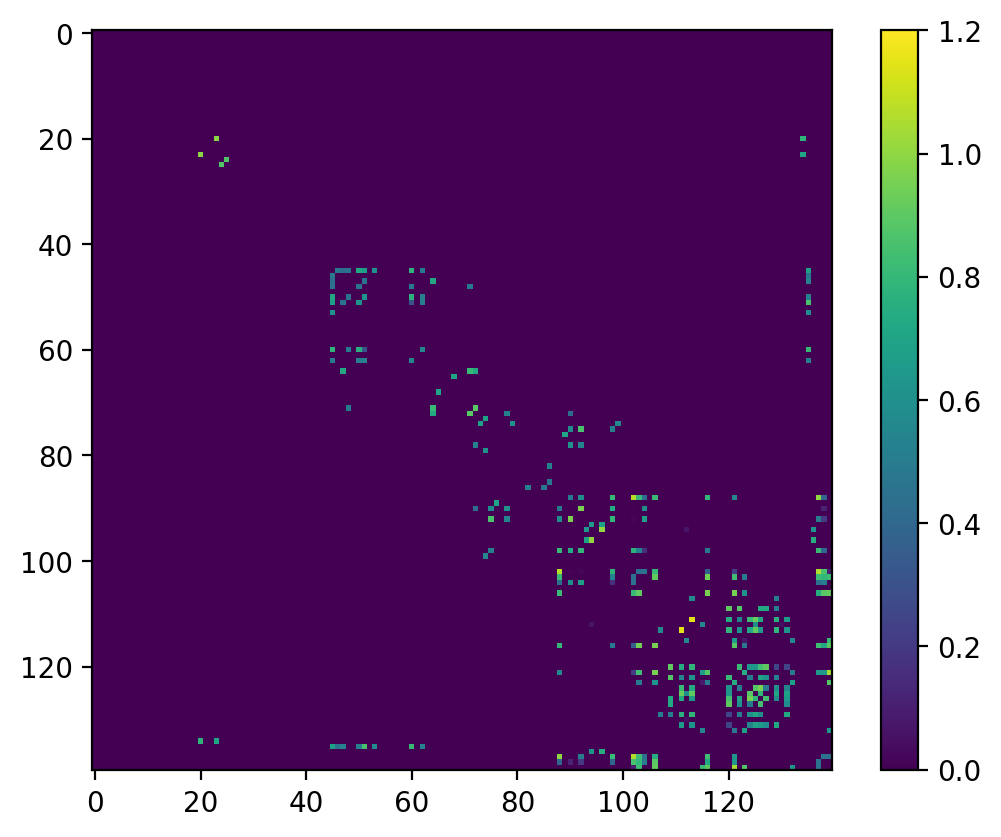

In [37]:
plt.imshow(final_metric, vmin=0, vmax=1.2); plt.colorbar();

### Merging

In [70]:
np.unravel_index(mw[68].argmax(), shape=mw[0].shape)

(66, 23)

In [66]:
np.abs(mw[7]).argmax()

1577

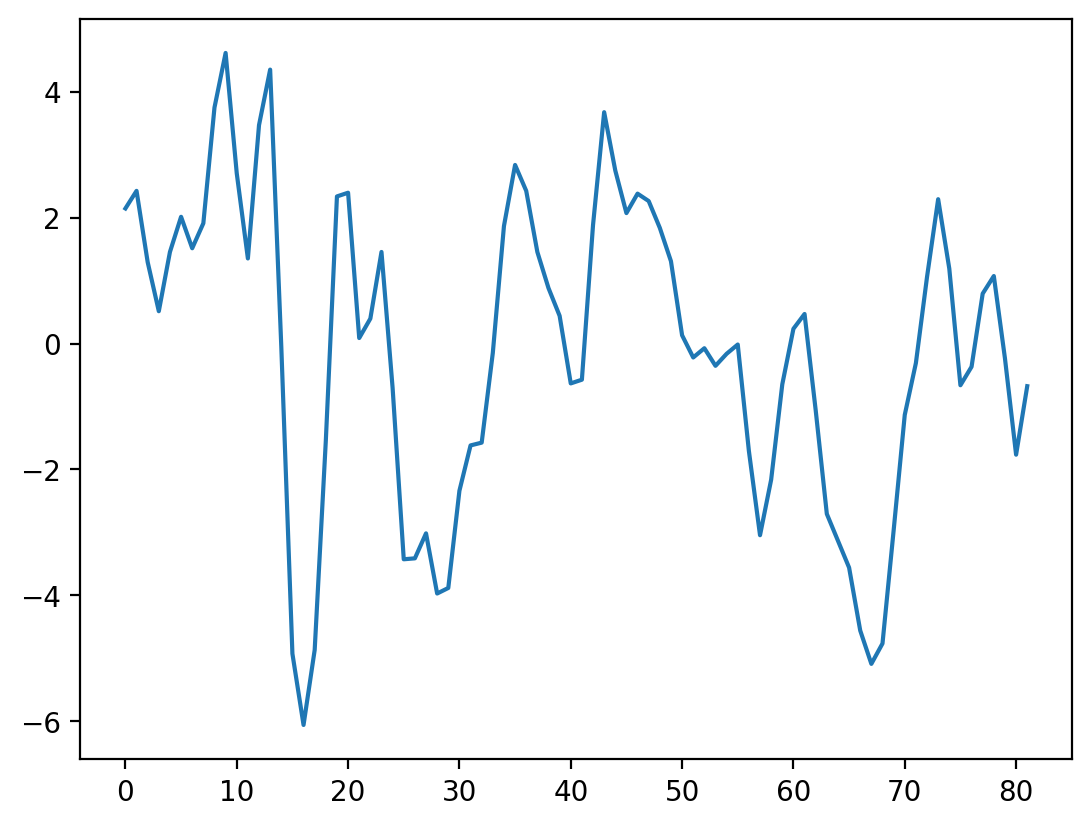

In [82]:
plt.plot(mw[4,28])